In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pmdarima


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.0 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split


In [19]:
# Đọc dữ liệu từ file CSV
df = pd.read_csv('/content/drive/MyDrive/StockData/SamSung.csv')

# Xử lý dữ liệu
df = df[['Date', 'Close', 'High']]  # Chỉ lấy cột 'Date', 'Close' và 'Volume'
df['Date'] = pd.to_datetime(df['Date'])
df = df.dropna().reset_index(drop=True)

In [27]:
# Chia train, test, validate theo tỉ lệ 7:2:1
train_size = int(0.8 * len(df))
test_size = int(0.2 * len(df))

train_data = df[:train_size]
test_data = df[train_size:]

# Tiến hành huấn luyện mô hình SARIMAX
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])
exog_train = np.array(train_data['High']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous

In [28]:
import pmdarima as pm
import statsmodels.api as sm

#Tìm mô hình SARIMAX tốt nhất
model = auto_arima(y_train, exogenous=exog_train, seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True)
# Fit mô hình SARIMAX (đảm bảo rằng seasonal_order được đặt nếu bạn muốn sử dụng SARIMAX)
model_fit = SARIMAX(y_train, exog=exog_train, order=model.order, seasonal_order=model.seasonal_order).fit()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=16351.192, Time=2.44 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=16341.864, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=16345.011, Time=0.22 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=16345.047, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=16340.252, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=16343.188, Time=0.13 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=16343.231, Time=0.17 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=16344.313, Time=0.48 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=16343.650, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=16343.642, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=16343.574, Time=0.33 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 4.270 seconds


In [29]:
x_test = np.array(test_data.index).reshape(-1, 1)

# Dự đoán trên tập kiểm thử (test_data)
y_test = np.array(test_data['Close'])
exog_test = np.array(test_data['High']).reshape(-1, 1)
y_pred_test = model_fit.predict(start=train_size, end=train_size+len(test_data)-1, exog=exog_test)
y_pred_test

array([59727.83743066, 59955.67486132, 59651.89162044, 59120.2709489 ,
       59424.05418978, 58816.48770802, 58816.48770802, 58816.48770802,
       58284.86703649, 58057.02960583, 58284.86703649, 57677.30055473,
       56614.05921166, 56538.11340144, 56462.16759122, 57981.08379561,
       58588.65027737, 59044.32513868, 60031.62067154, 60335.40391242,
       60411.34972263, 60411.34972263, 60411.34972263, 60715.13296351,
       60639.18715329, 60259.4581022 , 60639.18715329, 61246.75363505,
       62309.99497812, 62461.88659856, 63297.29051098, 63221.34470076,
       62309.99497812, 61550.53687593, 62461.88659856, 62537.83240878,
       61778.37430659, 61398.64525549, 62006.21173725, 62006.21173725,
       61778.37430659, 61778.37430659, 62461.88659856, 62461.88659856,
       62309.99497812, 62006.21173725, 61778.37430659, 61626.48268615,
       60867.02458395, 61398.64525549, 61474.59106571, 60107.56648176,
       60563.24134307, 60867.02458395, 60411.34972263, 60715.13296351,
      

In [30]:
# Dự đoán giá 30 ngày tiếp theo

next_dates = pd.date_range(start=df['Date'].iloc[-1], periods=30, freq='D')

mean_volume = np.mean(df['High'])
exog_next = np.full((30, 1), mean_volume)
# Tính chỉ số bắt đầu và kết thúc cho dự đoán
start_index = len(df) - len(y_test)
end_index = len(df) - 1

# Tạo mảng exogenous kết hợp cho tập kiểm thử và 30 ngày tiếp theo
exog_combined = np.concatenate((exog_test, exog_next))

# Dự đoán cho tập kiểm thử và 30 ngày tiếp theo
y_pred_combined = model_fit.predict(start=train_size, end=train_size + len(test_data) + 29, exog=exog_combined)

# Tách phần dự đoán cho 30 ngày tiếp theo
y_pred_next_30_days = y_pred_combined[-30:]

# Chuẩn bị DataFrame cho đồ thị
next_30_days = pd.DataFrame({'Date': next_dates, 'Predicted_Close': y_pred_next_30_days})
y_pred_combined



array([59727.83743066, 59955.67486132, 59651.89162044, 59120.2709489 ,
       59424.05418978, 58816.48770802, 58816.48770802, 58816.48770802,
       58284.86703649, 58057.02960583, 58284.86703649, 57677.30055473,
       56614.05921166, 56538.11340144, 56462.16759122, 57981.08379561,
       58588.65027737, 59044.32513868, 60031.62067154, 60335.40391242,
       60411.34972263, 60411.34972263, 60411.34972263, 60715.13296351,
       60639.18715329, 60259.4581022 , 60639.18715329, 61246.75363505,
       62309.99497812, 62461.88659856, 63297.29051098, 63221.34470076,
       62309.99497812, 61550.53687593, 62461.88659856, 62537.83240878,
       61778.37430659, 61398.64525549, 62006.21173725, 62006.21173725,
       61778.37430659, 61778.37430659, 62461.88659856, 62461.88659856,
       62309.99497812, 62006.21173725, 61778.37430659, 61626.48268615,
       60867.02458395, 61398.64525549, 61474.59106571, 60107.56648176,
       60563.24134307, 60867.02458395, 60411.34972263, 60715.13296351,
      

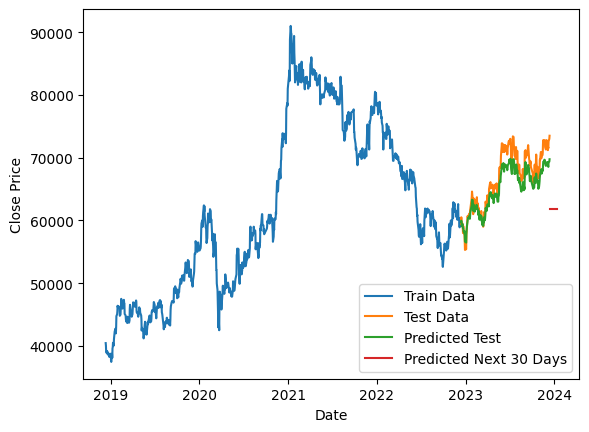

In [31]:
# Vẽ đồ thị
#plt.figure(figsize=(15, 8))
plt.plot(train_data['Date'], train_data['Close'], label='Train Data')
plt.plot(test_data['Date'], test_data['Close'], label='Test Data')
plt.plot(test_data['Date'], y_pred_test, label='Predicted Test')
plt.plot(next_30_days['Date'], next_30_days['Predicted_Close'], label='Predicted Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [32]:
# Tính MAE
test_mae = mean_absolute_error(y_test, y_pred_test)

# Tính toán RMSE
test_rmse = np.sqrt(np.mean((y_pred_test - y_test)**2))

# Tính MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

test_mape = mean_absolute_percentage_error(y_test, y_pred_test)

# Làm tròn đến số thứ 3 sau dấu phẩy
test_mae = round(test_mae, 3)
test_rmse = round(test_rmse, 3)
test_mape = round(test_mape, 3)

print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)

Testing MAE: 1772.377
Testing RMSE: 2065.868
Testing MAPE: 2.568


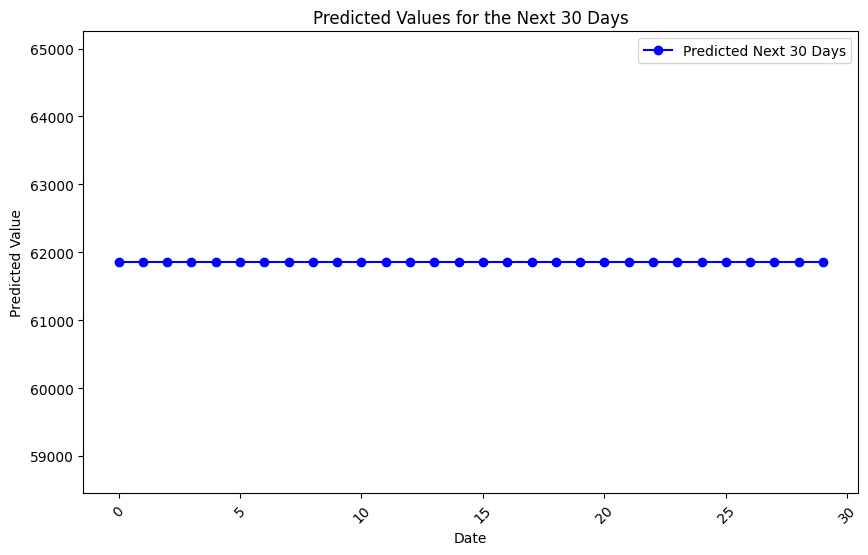

In [33]:
# Vẽ biểu đồ
plt.figure(figsize=(10, 6)) # Set the figure size
plt.plot(y_pred_next_30_days, marker='o', color='b', label='Predicted Next 30 Days')

# Đặt tiêu đề và nhãn
plt.title('Predicted Values for the Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Predicted Value')
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.legend()

# Hiển thị biểu đồ
plt.show()


